# Plot surface currents, wind speeds and salinity for SOG point 

In [65]:
import os
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.parser import parse
from salishsea_tools import viz_tools, utilities
import seaborn as sns
sns.set(style="whitegrid")

In [66]:
# _time: extended time period to plot up
# _model: time period of model simulations to overlay on longer time series

# - freshet and high winds time period
start_time = '30 may 2015'
end_time   = '22 jun 2015'
start_model = '2015-06-05'
end_model   = '2015-06-12'

# - non-freshet and low winds time period 
# start_time = '26 nov 2017'
# end_time   = '14 dec 2017'
# start_model = '1 dec 2017'
# end_model   = '7 dec 2017'

# location to plot
loc = 'SOG'

# output netcdf to save data to
in_current_netcdf = loc + '_current_timeseries_' + ''.join(start_time.split()) + '_' + ''.join(end_time.split()) + '.nc'
in_wind_netcdf    = loc + '_wind_timeseries_' + ''.join(start_time.split()) + '_' + ''.join(end_time.split()) + '.nc'
in_salty_netcdf   = loc + '_salinity_timeseries_' + ''.join(start_time.split()) + '_' + ''.join(end_time.split()) + '.nc'

In [67]:
out_fig_name = loc + '_current_wind_salinity_' + ''.join(start_time.split()) + '_' + ''.join(end_time.split()) + '.jpeg'
out_fig_name

'SOG_current_wind_salinity_30may2015_22jun2015.jpeg'

### load files for plotting

In [68]:
sfc_current = xr.open_dataset(in_current_netcdf)
wind = xr.open_dataset(in_wind_netcdf)
salty = xr.open_dataset(in_salty_netcdf)

In [69]:
sfc_current

<xarray.Dataset>
Dimensions:        (time_counter: 576)
Coordinates:
    depthu         float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2015-05-30T00:30:00 ...
Data variables:
    uspd           (time_counter) float32 ...

In [70]:
wind

<xarray.Dataset>
Dimensions:       (time_counter: 576)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2015-05-30 ...
Data variables:
    wspd          (time_counter) float32 ...

In [71]:
salty

<xarray.Dataset>
Dimensions:        (time_counter: 576)
Coordinates:
    deptht         float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2015-05-30T00:30:00 ...
Data variables:
    salinity       (time_counter) float32 ...

In [72]:
sfc_current.uspd

<xarray.DataArray 'uspd' (time_counter: 576)>
array([ 0.785415,  0.706093,  0.645309, ...,  0.236897,  0.237069,  0.332681], dtype=float32)
Coordinates:
    depthu         float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2015-05-30T00:30:00 ...

In [73]:
sfc_current

<xarray.Dataset>
Dimensions:        (time_counter: 576)
Coordinates:
    depthu         float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2015-05-30T00:30:00 ...
Data variables:
    uspd           (time_counter) float32 0.785415 0.706093 0.645309 ...

### Extract vectors with velocity and time values used in model run only

In [74]:
sfc_current_model = sfc_current.uspd.sel(time_counter=slice(start_model, end_model))
time_current_model = sfc_current.time_counter.sel(time_counter=slice(start_model, end_model))

### Exctract vectors for wind speed and time values used in model run only

In [75]:
wind_model = wind.wspd.sel(time_counter=slice(start_model, end_model))
time_wind_model = wind.time_counter.sel(time_counter=slice(start_model, end_model))

### Extract vectors for salinity  and time values used in model run only

In [76]:
salty_model = salty.salinity.sel(time_counter=slice(start_model, end_model))
time_salty_model = salty.time_counter.sel(time_counter=slice(start_model, end_model))

In [77]:
# calculate a running average 
uspd_avg = sfc_current.uspd.rolling(time_counter=12,center=True).mean()
wspd_avg = wind.wspd.rolling(time_counter=12,center=True).mean()
salty_avg = salty.salinity.rolling(time_counter=12,center=True).mean()

### Plot up x-array current speed, 10-m wind speed and salinity

2015 Fraser River freshet was on 6/5/2015 at just under 8000 m^3

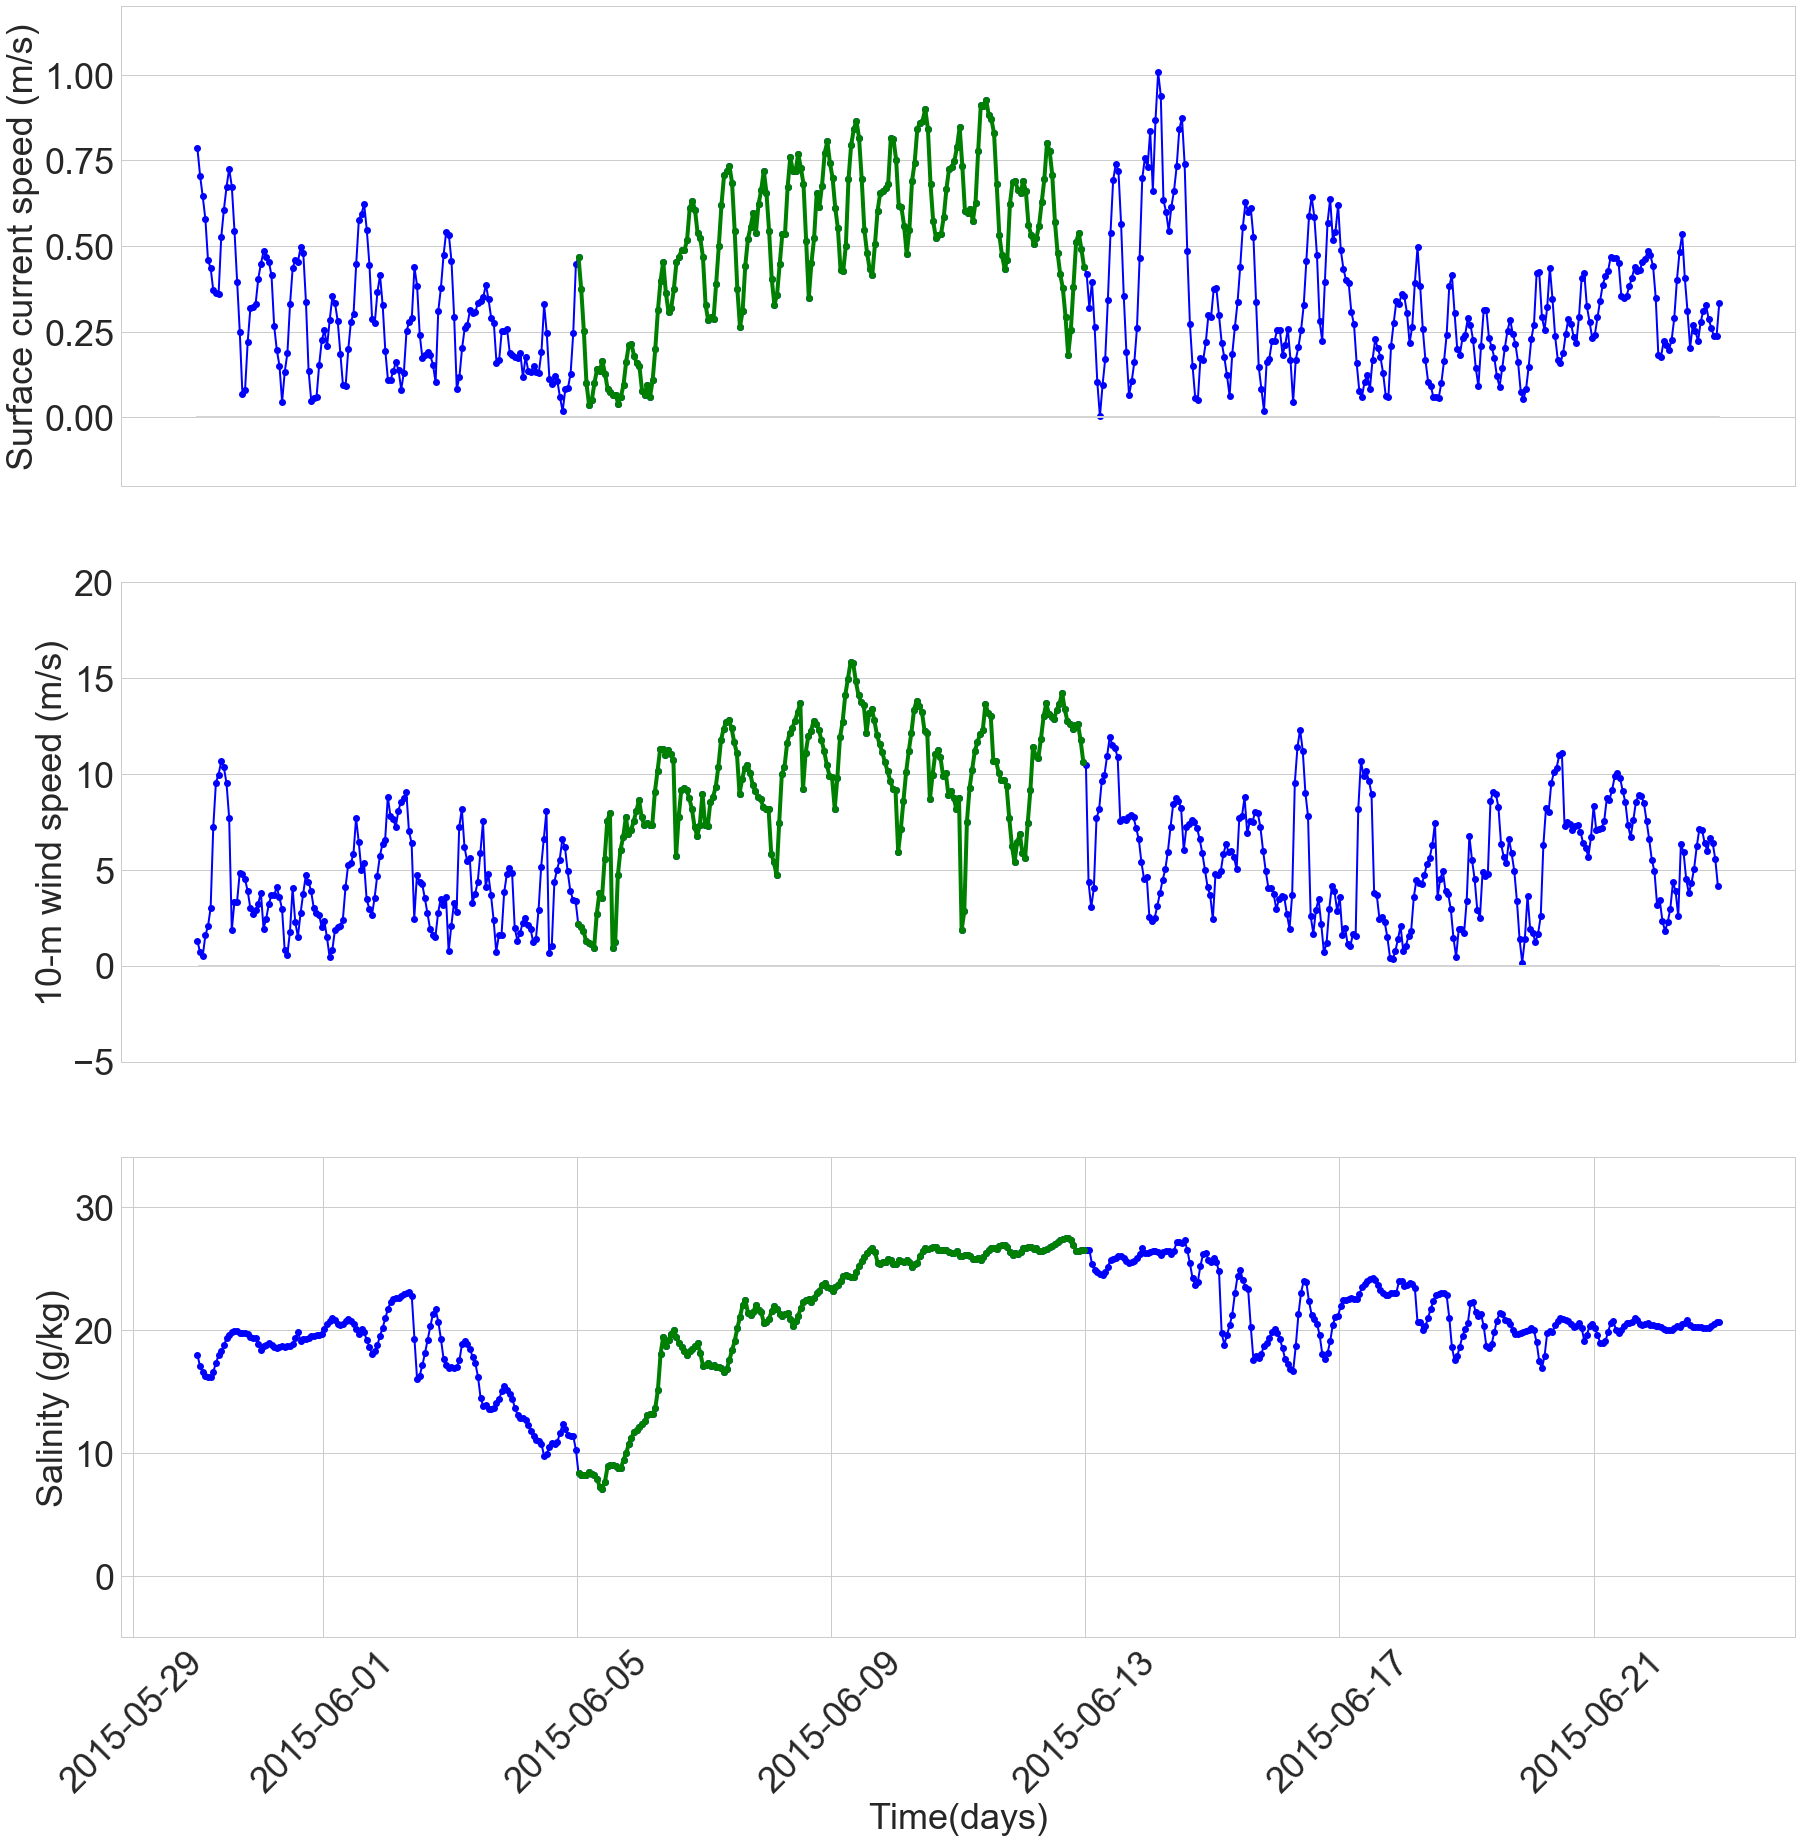

In [78]:
fs = 36
fig = plt.figure(figsize=(30,30))

# set up axes
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# define axes fontsize
ax1.labelsize=fs
ax2.labelsize=fs
ax3.labelsize=fs

# create a vector of zeros to plot up line at y=0 (for frame of reference)
zerline = np.zeros_like(sfc_current.uspd[:])

# plot surface level, Salish Sea Cast current speed over ~3-week period
speed_ax = ax1.plot(sfc_current.time_counter, sfc_current.uspd,'bo-',linewidth=2)
wind_ax = ax2.plot(wind.time_counter, wind.wspd,'bo-',linewidth=2)
salty_ax = ax3.plot(salty.time_counter, salty.salinity,'bo-',linewidth=2)

# Add the surface current, wind speeds and salinity during 1-week model run time 
speed_model_ax = ax1.plot(time_current_model, sfc_current_model,'go-',linewidth=4)
wind_model_ax  = ax2.plot(time_wind_model, wind_model,'go-',linewidth=4)
salty_model_ax = ax3.plot(time_salty_model, salty_model,'go-',linewidth=4)

# add a line at zero to surface current and wind speed graphics
ax1.plot(sfc_current.time_counter,zerline,'lightgrey', linewidth = 2)
ax2.plot(sfc_current.time_counter,zerline,'lightgrey', linewidth = 2)

# adjust axis labels, ticks, etc., for:
# - surface currents
ax1.set_ylabel('Surface current speed (m/s)', fontsize=fs)
ax1.set_ylim(-.2,1.2)
ax1.tick_params(labelsize=fs)
ax1.set_xticks(ticks=[])
# - winds
ax2.set_ylabel('10-m wind speed (m/s)', fontsize=fs)
ax2.set_ylim(-5,20)
ax2.tick_params(labelsize=fs)
ax2.set_xticks(ticks=[])
# - salinity
ax3.set_ylabel('Salinity (g/kg)', fontsize=fs)
ax3.set_ylim(-5,34)
ax3.set_xlabel('Time(days)', fontsize=fs)
ax3.tick_params(labelsize=fs)

# I don't know how to attribute rotation to ax3, but this works!
plt.xticks(rotation=45)

# Give the subplots some breathing room...Ahhh....
plt.subplots_adjust(hspace=0.2)

# It's a wrap.  Save it! 
plt.savefig(out_fig_name, format='jpeg', dpi = 600)